In [1]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')
#
# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment2/'
# FOLDERNAME = 'Masters_Project/data_processing'
# assert FOLDERNAME is not None, "[!] Enter the foldername."
#
# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
#

In [4]:
# Load triggers data

import numpy as np 
from sklearn.model_selection import train_test_split

data = np.load("./second_collection_triggs_rels.npz")

triggers_only = True 
releases_only = False 
assert not(triggers_only & releases_only), "Can only pick one at one time"

# Some clunky code below
# Check the numner of different users
users = []
for key in data:
    user, mode = key.split("_")
    users.append(user)
users = np.array(users, dtype=str)
users = np.unique(users)

Xraw = []
yraw = []
for key in data:
    user, mode = key.split("_")
    if triggers_only and (mode=="releases"): continue
    if releases_only and (mode=="triggers"): continue
    
    sig = data[key]
    Xraw.append(sig)

    # lab = int(user[1])-1  # Number for identifying user
    yraw.append(np.full(len(sig), np.argwhere(users==user)[0]))

Xraw = np.concatenate(Xraw)
yraw = np.concatenate(yraw)
print("Raw data shape: ", Xraw.shape)
print("Labels shape: ", yraw.shape)
print("Unique labels: ", np.unique(yraw))

Raw data shape:  (7931, 30)
Labels shape:  (7931,)
Unique labels:  [0 1 2]


Size of test set: (1190, 30)
Size of train set: (6741, 30)
Fraction of single class in test set:  0.3033613445378151


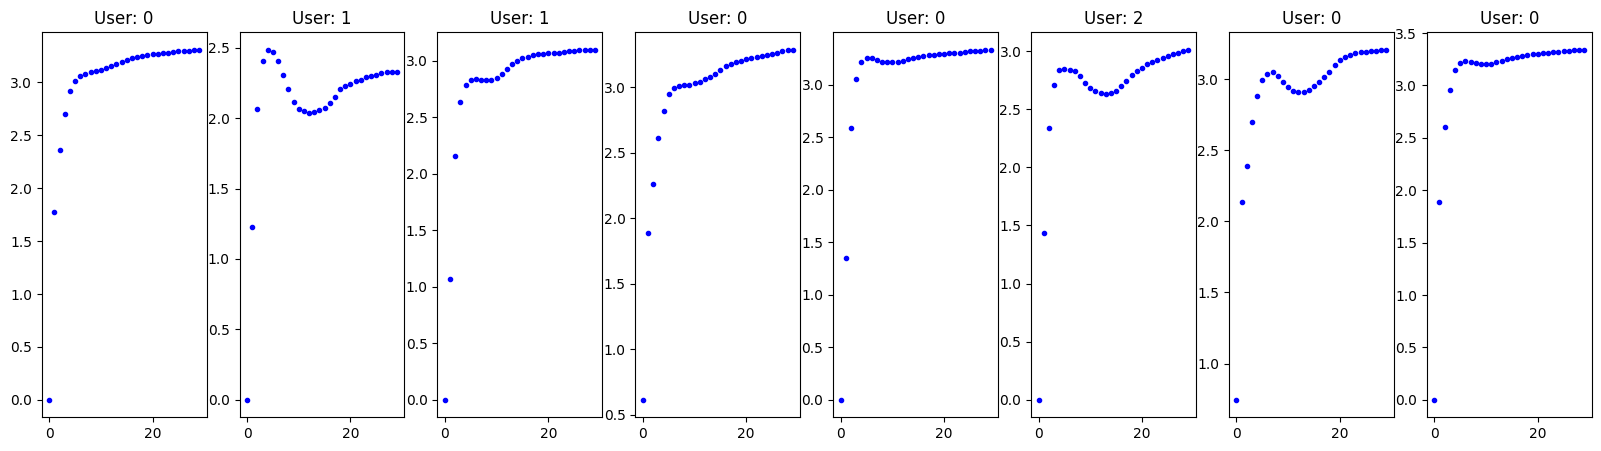

In [5]:
# Split data into test  and train set
Xtrain, Xtest, ytrain, ytest = train_test_split(Xraw, yraw, test_size=0.15, random_state=42)
print("Size of test set:", Xtest.shape)
print("Size of train set:", Xtrain.shape)
print("Fraction of single class in test set: ", np.mean(ytest==0))

# Plot the first 8 cases from train test
import matplotlib.pyplot as plt
nplots = 8
plt.figure(figsize=(20, 5))
for i in range(nplots):
    plt.subplot(1, nplots, i+1)
    plt.plot(range(len(Xtrain[i])), Xtrain[i], "b.")
    plt.title(f"User: {ytrain[i]}")

In [6]:
# The normalization should always be relative to the train set but I this simple norm is okay for nowk 
# Skip this cell to try unormalised data
def normalize(x):   
    # Use quantities from training data set
    avgmax = np.max(x, axis=1)[:, np.newaxis]
    return x / avgmax 

Xtrain = normalize(Xtrain) 
Xtest = normalize(Xtest)

In [7]:
# Try to code a simple network
import torch

device = torch.device('cpu')
dtype = torch.float32

# Function to print accuracy of validation set while training
def checkAcc(x, y, model, set="Train set"):
    scores = model(x)
    _, preds = scores.max(1)    # Returns indices alongside axis=1
    num_correct = (preds == y).sum()
    num_samples = preds.size(0)
    acc = float(num_correct) / num_samples
    print(f"{set} Accuracy: {num_correct} / {num_samples} = {acc:.2f}")

# Define a general procedure to train a model
def trainModel(model, loss_fn, optimizer, x, y, N=1000):
    for t in range(N):

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # Internally, this call will compute gradients for all learnable parameters in the model.
        loss.backward()

        # Update weights
        optimizer.step()
        # Zero the gradients after weight updates.
        optimizer.zero_grad()

        with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
            if t%100==0:
                print(f"Iteration {t}\nLoss: {loss.item()}")
                checkAcc(x, y, model)

In [8]:
# Pass data to tensors
x = torch.tensor(Xtrain, device=device, dtype=dtype)
y = torch.tensor(ytrain, device=device, dtype=torch.long)

xt= torch.tensor(Xtest, device=device, dtype=dtype)
yt= torch.tensor(ytest, device=device, dtype=torch.long)

In [11]:
# Simple Fully Connected NN
# Gets 0.7 accuracy after 10000 iterations, but performs better with unormalised parameters (0.8)
N, D_in, H, D_out = len(Xtrain), 30, 1000, 3 

model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        ).to(device)

# Loss function to use - check available functions on pytorch
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainModel(model, loss_fn, optimizer, x, y, 5000)
# Test model on test data
with torch.no_grad():
    checkAcc(xt, yt, model, set="\nTest")

Iteration 0
Loss: 1.0953837633132935
Train set Accuracy: 2612 / 6741 = 0.39
Iteration 100
Loss: 0.7957890033721924
Train set Accuracy: 4406 / 6741 = 0.65
Iteration 200
Loss: 0.6939847469329834
Train set Accuracy: 4715 / 6741 = 0.70
Iteration 300
Loss: 0.6462720036506653
Train set Accuracy: 4904 / 6741 = 0.73
Iteration 400
Loss: 0.6164259910583496
Train set Accuracy: 4968 / 6741 = 0.74
Iteration 500
Loss: 0.5918241143226624
Train set Accuracy: 5073 / 6741 = 0.75
Iteration 600
Loss: 0.5725991725921631
Train set Accuracy: 5140 / 6741 = 0.76
Iteration 700
Loss: 0.5564095377922058
Train set Accuracy: 5185 / 6741 = 0.77
Iteration 800
Loss: 0.5451862215995789
Train set Accuracy: 5242 / 6741 = 0.78
Iteration 900
Loss: 0.5305703282356262
Train set Accuracy: 5279 / 6741 = 0.78
Iteration 1000
Loss: 0.5188084840774536
Train set Accuracy: 5342 / 6741 = 0.79
Iteration 1100
Loss: 0.5088436007499695
Train set Accuracy: 5364 / 6741 = 0.80
Iteration 1200
Loss: 0.5020875334739685
Train set Accuracy: 5388

In [12]:
# To run convolutions, need to modify shape of input
x = x.view(x.shape[0], 1, x.shape[1])
xt = xt.view(xt.shape[0], 1, xt.shape[1])

In [14]:
# NN with 2 Convolution Layers
# Performs best with normalised data, but still works with unormalised
# Currently overfitting data from second_collection

class deepModel(torch.nn.Module):
    def __init__(self):
        super(deepModel, self).__init__()

        # Number of filters on each layer
        D1 = 12 
        D2 = 12 

        self.layer1 = torch.nn.Sequential(
                torch.nn.Conv1d(1, D1, kernel_size=3, padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=2)
                )
        
        self.layer2 = torch.nn.Sequential(
                torch.nn.Conv1d(D1, D2, kernel_size=3, padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=3)
                )
        # self.drop_out = torch.nn.Dropout()
        self.fc1 = torch.nn.Linear(D2 * 5, 100)    
        self.fc2 = torch.nn.Linear(100, 3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)   # Flatten tensor
        # out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model_deep = deepModel().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
# optim_deep = torch.optim.SGD(model_deep.parameters(), lr=1e-3, momentum=0.9)
optim_deep = torch.optim.Adam(model_deep.parameters(), lr=1e-3)

trainModel(model_deep, loss_fn, optim_deep, x, y, 5000)
with torch.no_grad():
    checkAcc(xt, yt, model_deep, set="\nTest")

Iteration 0
Loss: 1.0970537662506104
Train set Accuracy: 2612 / 6741 = 0.39
Iteration 100
Loss: 0.7105497717857361
Train set Accuracy: 4652 / 6741 = 0.69
Iteration 200
Loss: 0.5630633234977722
Train set Accuracy: 5186 / 6741 = 0.77
Iteration 300
Loss: 0.5031134486198425
Train set Accuracy: 5397 / 6741 = 0.80
Iteration 400
Loss: 0.47390440106391907
Train set Accuracy: 5487 / 6741 = 0.81
Iteration 500
Loss: 0.45545539259910583
Train set Accuracy: 5515 / 6741 = 0.82
Iteration 600
Loss: 0.4464561343193054
Train set Accuracy: 5554 / 6741 = 0.82
Iteration 700
Loss: 0.4338470995426178
Train set Accuracy: 5589 / 6741 = 0.83
Iteration 800
Loss: 0.42950862646102905
Train set Accuracy: 5612 / 6741 = 0.83
Iteration 900
Loss: 0.4206613302230835
Train set Accuracy: 5611 / 6741 = 0.83
Iteration 1000
Loss: 0.4149796664714813
Train set Accuracy: 5633 / 6741 = 0.84
Iteration 1100
Loss: 0.40938064455986023
Train set Accuracy: 5657 / 6741 = 0.84
Iteration 1200
Loss: 0.4111005663871765
Train set Accuracy: 

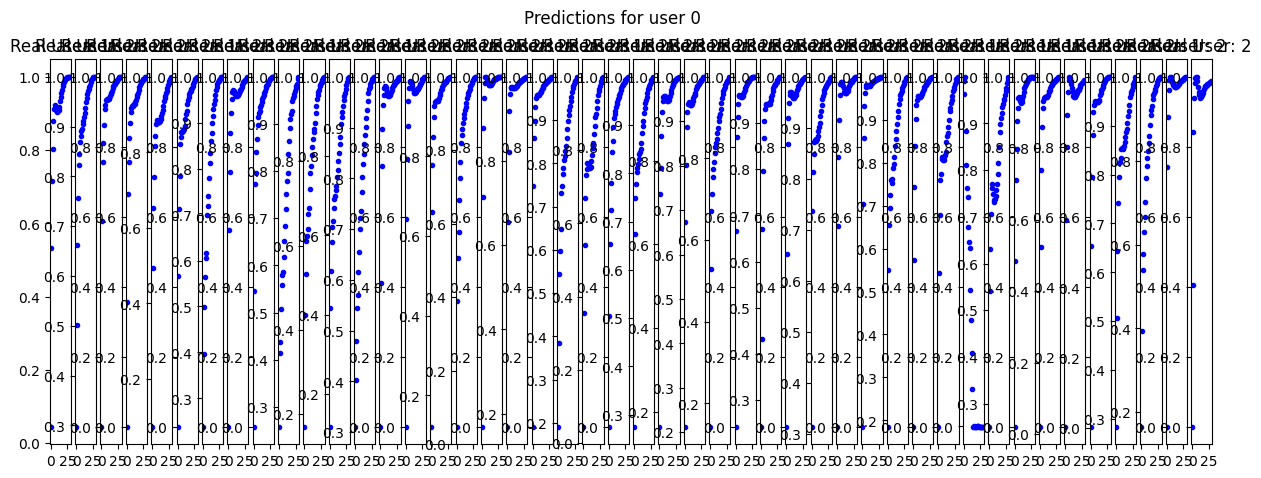

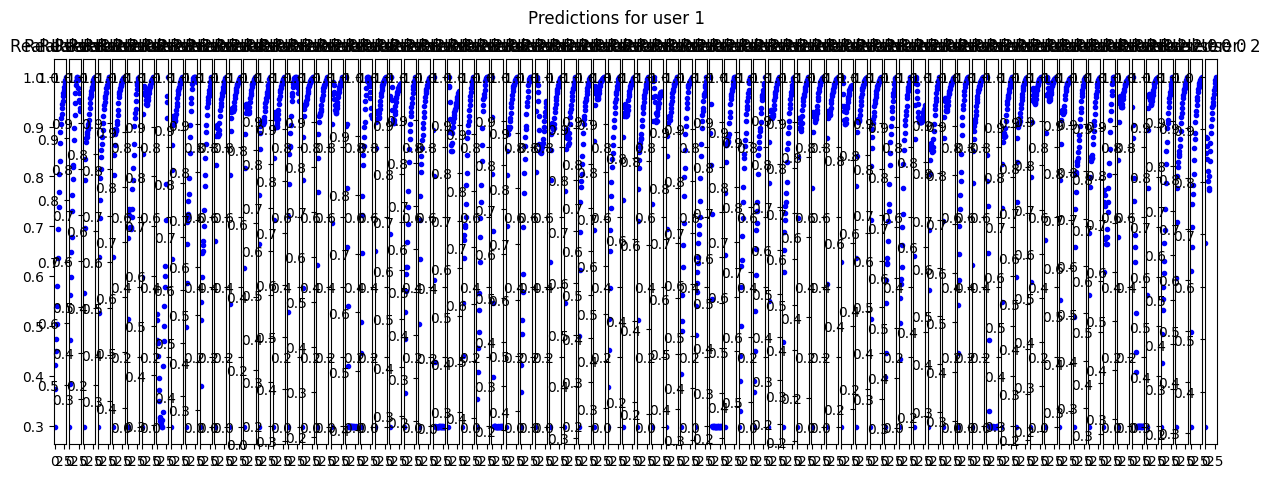

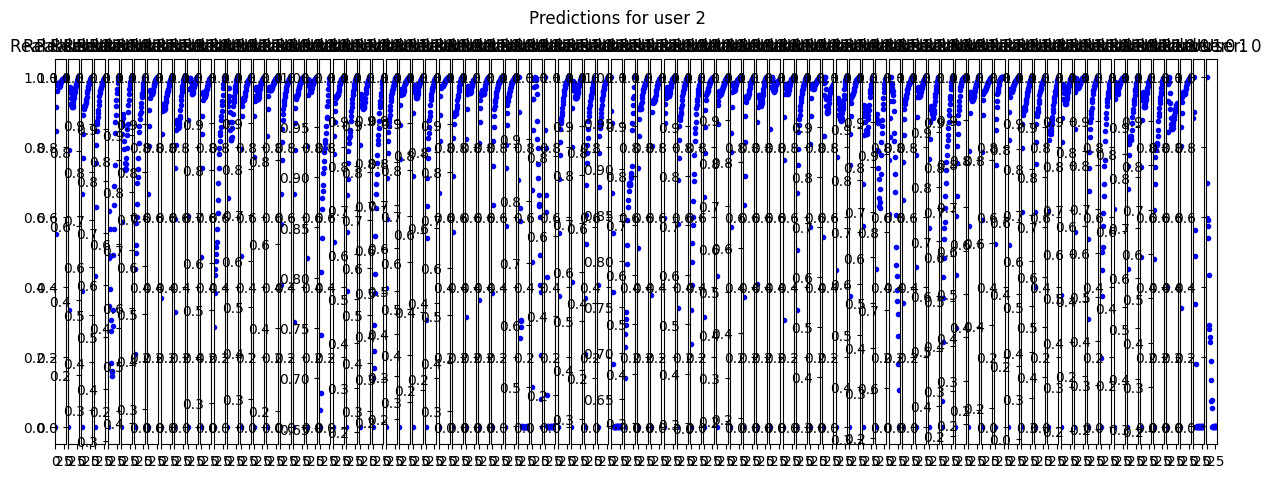

In [15]:
import matplotlib.pyplot as plt

def plotTest(Xtest, ytest, predictions, misclassifications_only=True):
    #TODO: Change figure to a square format, to make plots visible
    for j in np.unique(predictions):

        usr = predictions==j
        if misclassifications_only:
            usr = (predictions==j) & (ytest!=j) 

        X1 = Xtest[usr]
        labels = ytest[usr]
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Predictions for user {j}")
        for i, (x, lab) in enumerate(zip(X1, labels)):
            plt.subplot(1, len(X1), i+1)
            plt.plot(range(len(x)), x, "b.")
            plt.title(f"Real User: {lab}")


# Plot results
with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
    scores = model_deep(xt)
    _, preds = scores.max(1)
    predictions = preds.detach().numpy()

plotTest(Xtest, ytest, predictions)
# plt.show()

In [ ]:
# Plot misclassifications from training
with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
    scores = model_deep(x)
    _, preds = scores.max(1)
    predictions = preds.detach().numpy()

plotTest(Xtrain, ytrain, predictions)